# Predicting Chronic Kidney Disease in Patients
![A chronic kidney disease infographic](https://imgur.com/QJyRWhz.jpg)


<b>The data science process:</b>
1. Define the problem.
2. Obtain the data.
3. Explore the data.
4. Model the data.
5. Evaluate the model.
6. Answer the problem.



<b>Helpful links:</b>
- [A set of chronic kidney disease (CKD) data and other biological factors](./chronic_kidney_disease_full.csv).
- [The CKD data dictionary](./chronic_kidney_disease_header.txt).
- [An article comparing the use of k-nearest neighbors and support vector machines on predicting CKD](./chronic_kidney_disease.pckd).

## Imports

In [401]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix, precision_score, recall_score

import matplotlib.pyplot as plt

%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))#to expand the size of my container so it can take fill up my entire monitor

plt.style.use('fivethirtyeight')
%config InlineBackend.figure_format = 'retina' #to enable higher quality plots on retina displays
pd.options.display.max_rows = 200 #increasing maximum viewable rows and columns
pd.options.display.max_columns = 200

## Step 1: Define the problem.

**Real-world problem**: Develop a medical diagnosis test that is better than our current diagnosis system for CKD.

**Data science problem**: Develop a medical diagnosis test that reduces both the number of false positives and the number of false negatives.

---

## Step 2: Obtain the data.

### 1. Read in the data.

In [402]:
ckd = pd.read_csv('chronic_kidney_disease_full.csv')

In [403]:
ckd.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,bu,sc,sod,pot,hemo,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,36.0,1.2,NaN,NaN,15.4,44.0,7800.0,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,18.0,0.8,NaN,NaN,11.3,38.0,6000.0,NaN,no,no,no,good,no,no,ckd
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,53.0,1.8,NaN,NaN,9.6,31.0,7500.0,NaN,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,56.0,3.8,111.0,2.5,11.2,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,26.0,1.4,NaN,NaN,11.6,35.0,7300.0,4.6,no,no,no,good,no,no,ckd


### After checking the data dictionary, we notice there are a few features or relationships you might be interested in checking out:

- First, I want to check the `ckd` variable to see if unbalanced classes would be an issue here. (A 38/62 split probably won't be problematic.)
- Secondly, since we want to predict `ckd`, I would probably want to compare each variable with `ckd` to see which variables appear to have predictive value.
- Next, I'll want to check the patterns of missingness. Are any variables missing extensively so that it will be problematic? Is there any missingness that is explained by the data dictionary? (i.e. tests not run due to certain thresholds being met?)
- Check out the distributions of each variable. Are there certain variables that overwhelmingly take on one value and thus might not be predictive?
- Lots of these variables have "blood" in the name. If I'm trying to do a linear model (i.e. logistic regression, linear regression), there might be some relationship among these features. (I'm not a doctor, so I'll err on the side of caution here!) If certain features are correlated, then I'll want to include interaction terms or I'll want to remove one of them when building a linear model.

---

## Step 3: Explore the data.

In [404]:
#checking for nulls
ckd.isnull().sum().sort_values(ascending=False)

rbc      152
rbcc     131
wbcc     106
pot       88
sod       87
pcv       71
pc        65
hemo      52
su        49
sg        47
al        46
bgr       44
bu        19
sc        17
bp        12
age        9
ba         4
pcc        4
htn        2
dm         2
cad        2
appet      1
pe         1
ane        1
class      0
dtype: int64

In [405]:
100 * ckd.isnull().sum() / ckd.shape[0]

age       2.25
bp        3.00
sg       11.75
al       11.50
su       12.25
rbc      38.00
pc       16.25
pcc       1.00
ba        1.00
bgr      11.00
bu        4.75
sc        4.25
sod      21.75
pot      22.00
hemo     13.00
pcv      17.75
wbcc     26.50
rbcc     32.75
htn       0.50
dm        0.50
cad       0.50
appet     0.25
pe        0.25
ane       0.25
class     0.00
dtype: float64

Data is missing from every column except for `class`. 

In particular, `rbc`, `wbcc`, and `rbcc` are missing over 100 observations each. 

We should be particularly concerned about the categories that are missing over 15% of their data. This is problematic and should be addressed.

### Suppose we drop every row that contains at least one missing value, (In the context of analysis with missing data, we call this a "complete case analysis," because we keep only the complete cases!) how many rows would remain in our dataframe? 

> There's a good visual on slide 15 of [this deck](https://liberalarts.utexas.edu/prc/_files/cs/Missing-Data.pckd) that shows what a complete case analysis looks like if you're interested.

In [406]:
ckd.shape

(400, 25)

In [407]:
ckd['y'] = [1 if i == 'ckd' else 0 for i in ckd['class']]

In [408]:
ckd['y'].value_counts(normalize=True)

1    0.625
0    0.375
Name: y, dtype: float64

- Unbalanced classes are usually a problem because our model has a tough time learning about the minority class. There's simply not enough data to learn the "pattern" or "behavior" of the minority class.
- To help a doctor or hospital admin to understand this, you'd probably say something along the lines of the rarer an illness is, the more difficult it becomes to recognize it.

In [409]:
ckd.dropna(axis = 0, how = 'any', inplace = False).shape

(158, 26)

In [410]:
ckd.dropna(axis = 0, how = 'any', inplace = False)['class'].value_counts(normalize=True)

notckd    0.727848
ckd       0.272152
Name: class, dtype: float64

We'd lose 242 rows, which accounts for 60% of out data.

Some downsides to this:
- Of these 242 rows, many of them do have information filled in for some of the cells. If we drop any observation that contains at least one missing value, then we're discarding a lot of data that exists!
- If "NaN" possibly means something (i.e. this test was not run), then discarding cells might be a bad idea. 
- By dropping values in this way, we drop 35 of our 150 "Not CKD" observations (23%) but drop 207 of our 250 "CKD" observations (83%!!!). This would affect the balance of our classes considerably and may create bias in our models.

Losing all of this data is inadvisable, so we'll keep all of my data.

If we think about it, this data was probably gathered by doctors and nurses. This gives us potential clues for why it's missing.

Some reasons why it's missing can be:
- Certain variables may be subjective. For example, two different doctors might arrive at two different conclusions for "appetite." What qualifies as "good" versus "poor?"
- For certain variables like "red blood cells," does it make sense to just leave it at "normal" versus "abnormal?" Are there multiple ways for red blood cells to be "abnormal?" This imprecision might make our test less effective than we'd like.
- Depending on the background of a particular patient (ethnicity, sex, etc.) what may be a healthy value for another person may not be for another.
- While we assume this isn't the case, it's always possible that the data we have are wrong.
    - Maybe lab results were mixed up (i.e. not connected to the correct patient).
    - Maybe machines aren't properly calibrated or some contamination occurred so our measurements are incorrect.

---

## Step 4: Model the data.

### POP QUIZ: If we wanted to create a model where no person who has CKD will ever be told that they do not have CKD. What (very simple, no machine learning needed) model can we create that will never tell a person with CKD that they do not have CKD?

<b>Answer:</b> Tell everyone they have CKD (<b>minimizing false negatives</b> and <b> maximizing the sensitivity</b> of our model).

We wouldn't want to do that of course because we'll be letting a whole host of people think they have kidney disease, which will unnecessarily stress them out!

### POP QUIZ: If we wanted to create a model where a person who doesn't have CKD will ever be told that they do have CKD. What (very simple, no machine learning needed) model can we create that will never tell a person with CKD that they do not have CKD?

<b>Answer:</b> Tell everyone they don't have CKD (<b>minimizing false positives</b> and <b>maximizing the specificity</b> of our model).

We wouldn't want to do this, because people who actually have kidney disease won't pursue any treatment, increasing their likelihood of early death.

### 12. Let's construct a logisitic regression model!

In [411]:
from sklearn.linear_model import LogisticRegression

In [412]:
ckd.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,bu,sc,sod,pot,hemo,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class,y
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,36.0,1.2,NaN,NaN,15.4,44.0,7800.0,5.2,yes,yes,no,good,no,no,ckd,1
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,18.0,0.8,NaN,NaN,11.3,38.0,6000.0,NaN,no,no,no,good,no,no,ckd,1
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,53.0,1.8,NaN,NaN,9.6,31.0,7500.0,NaN,no,yes,no,poor,no,yes,ckd,1
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,56.0,3.8,111.0,2.5,11.2,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,ckd,1
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,26.0,1.4,NaN,NaN,11.6,35.0,7300.0,4.6,no,no,no,good,no,no,ckd,1


In [413]:
ckd['class'] = ckd['class'].map({'notckd' : 0, 'ckd' : 1})

In [414]:
ckd['class'].value_counts(normalize=True)

1    0.625
0    0.375
Name: class, dtype: float64

In [415]:
ckd.dtypes

age      float64
bp       float64
sg       float64
al       float64
su       float64
rbc       object
pc        object
pcc       object
ba        object
bgr      float64
bu       float64
sc       float64
sod      float64
pot      float64
hemo     float64
pcv      float64
wbcc     float64
rbcc     float64
htn       object
dm        object
cad       object
appet     object
pe        object
ane       object
class      int64
y          int64
dtype: object

Let's make some dummy variables.

We'll set up our qualitative ones in a dataframe called `qual` (for qualitative) and our quantitative variables in a dataframe called `quant` (for quantitative).

In [416]:
rbc_abnormal = pd.get_dummies(ckd['rbc'])['abnormal']
pc_abnormal = pd.get_dummies(ckd['pc'])['abnormal']
pcc_present = pd.get_dummies(ckd['pcc'])['present']
ba_present = pd.get_dummies(ckd['ba'])['present']
htn_yes = pd.get_dummies(ckd['htn'])['yes']
dm_yes = pd.get_dummies(ckd['dm'])['yes']
cad_yes = pd.get_dummies(ckd['cad'])['yes']
appet_poor = pd.get_dummies(ckd['appet'])['poor']
pe_yes = pd.get_dummies(ckd['pe'])['yes']
ane_yes = pd.get_dummies(ckd['ane'])['yes']

In [417]:
quant = ckd[['age', 'bp', 'sg', 'al', 'su', 'bgr',
                 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv',
                 'wbcc', 'rbcc']]

qual = pd.DataFrame([ane_yes, pe_yes, rbc_abnormal, pc_abnormal,
                     pcc_present, ba_present, htn_yes, dm_yes,
                     cad_yes, appet_poor], index=['ane_yes', 'pe_yes', 'rbc_abnormal',
                                                  'pc_abnormal', 'pcc_present',
                                                  'ba_present', 'htn_yes', 'dm_yes',
                                                  'cad_yes', 'appet_poor']).T

In [418]:
X = quant.merge(right = qual, left_index = True, right_index = True)

In [419]:
X

,age,bp,sg,al,su,bgr,bu,sc,sod,pot,hemo,pcv,wbcc,rbcc,ane_yes,pe_yes,rbc_abnormal,pc_abnormal,pcc_present,ba_present,htn_yes,dm_yes,cad_yes,appet_poor
0,48.0,80.0,1.020,1.0,0.0,121.0,36.0,1.2,NaN,NaN,15.4,44.0,7800.0,5.2,0,0,0,0,0,0,1,1,0,0
1,7.0,50.0,1.020,4.0,0.0,NaN,18.0,0.8,NaN,NaN,11.3,38.0,6000.0,NaN,0,0,0,0,0,0,0,0,0,0
2,62.0,80.0,1.010,2.0,3.0,423.0,53.0,1.8,NaN,NaN,9.6,31.0,7500.0,NaN,1,0,0,0,0,0,0,1,0,1
3,48.0,70.0,1.005,4.0,0.0,117.0,56.0,3.8,111.0,2.5,11.2,32.0,6700.0,3.9,1,1,0,1,1,0,1,0,0,1
4,51.0,80.0,1.010,2.0,0.0,106.0,26.0,1.4,NaN,NaN,11.6,35.0,7300.0,4.6,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,55.0,80.0,1.020,0.0,0.0,140.0,49.0,0.5,150.0,4.9,15.7,47.0,6700.0,4.9,0,0,0,0,0,0,0,0,0,0
396,42.0,70.0,1.025,0.0,0.0,75.0,31.0,1.2,141.0,3.5,16.5,54.0,7800.0,6.2,0,0,0,0,0,0,0,0,0,0
397,12.0,80.0,1.020,0.0,0.0,100.0,26.0,0.6,137.0,4.4,15.8,49.0,6600.0,5.4,0,0,0,0,0,0,0,0,0,0
398,17.0,60.0,1.025,0.0,0.0,114.0,50.0,1.0,135.0,4.9,14.2,51.0,7200.0,5.9,0,0,0,0,0,0,0,0,0,0


There were a lot of data munging issues with `X` with the NAs in the dataframe were throwing it off. 

We're going to take a **very** rudimentary approach by filling in the mean.

### NOTE: FILLING IN THE MEAN IS USUALLY CATASTROPHIC FOR YOUR ANALYSIS. 

This quick fix leads to lots negative side effects, especially if we're attempting to conduct inference. We're using this quick fix so as to not get loss in the weeds. 

Mean imputation is inadvisable in most circumstances. *Proceed with caution.*

In [420]:
X_train, X_test, y_train, y_test = train_test_split(X.fillna(X.mean()),
                                                    ckd['y'],
                                                    test_size = 0.3, 
                                                    random_state = 42)

In [421]:
X_test

,age,bp,sg,al,su,bgr,bu,sc,sod,pot,hemo,pcv,wbcc,rbcc,ane_yes,pe_yes,rbc_abnormal,pc_abnormal,pcc_present,ba_present,htn_yes,dm_yes,cad_yes,appet_poor
209,19.000000,70.000000,1.020000,0.000000,0.000000,148.036517,57.425722,3.072454,137.528754,4.627244,11.500000,38.884498,6900.000000,4.707435,0,0,0,0,0,0,0,0,0,0
280,47.000000,80.000000,1.017408,1.016949,0.450142,93.000000,33.000000,0.900000,144.000000,4.500000,13.300000,52.000000,8100.000000,5.200000,0,0,0,0,0,0,0,0,0,0
33,60.000000,100.000000,1.020000,2.000000,0.000000,140.000000,55.000000,2.500000,137.528754,4.627244,10.100000,29.000000,8406.122449,4.707435,0,0,1,1,0,0,1,0,0,1
210,59.000000,100.000000,1.015000,4.000000,2.000000,255.000000,132.000000,12.800000,135.000000,5.700000,7.300000,20.000000,9800.000000,3.900000,1,0,0,0,0,0,1,1,1,0
93,73.000000,100.000000,1.010000,3.000000,2.000000,295.000000,90.000000,5.600000,140.000000,2.900000,9.200000,30.000000,7000.000000,3.200000,0,0,1,1,1,0,1,1,1,1
84,59.000000,70.000000,1.010000,3.000000,0.000000,76.000000,186.000000,15.000000,135.000000,7.600000,7.100000,22.000000,3800.000000,2.100000,1,1,0,1,0,0,1,0,0,1
329,33.000000,60.000000,1.025000,0.000000,0.000000,80.000000,25.000000,0.900000,146.000000,3.500000,14.100000,48.000000,7800.000000,5.100000,0,0,0,0,0,0,0,0,0,0
94,65.000000,70.000000,1.010000,0.000000,0.000000,93.000000,66.000000,1.600000,137.000000,4.500000,11.600000,36.000000,11900.000000,3.900000,0,0,0,0,0,0,0,1,0,0
266,55.000000,80.000000,1.020000,0.000000,0.000000,133.000000,17.000000,1.200000,135.000000,4.800000,13.200000,41.000000,6800.000000,5.300000,0,0,0,0,0,0,0,0,0,0
126,70.000000,90.000000,1.015000,0.000000,0.000000,144.000000,125.000000,4.000000,136.000000,4.600000,12.000000,37.000000,8200.000000,4.500000,0,1,0,0,0,0,1,1,0,1


In [422]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

In [423]:
pipe_lr = Pipeline([
    ('poly', PolynomialFeatures(interaction_only=False, include_bias=False)), 
    ('sc', StandardScaler()),
    ('lr', LogisticRegression())
    ])

In [424]:
cross_val_score(pipe_lr, X_train, y_train, cv = 5).mean()

0.9785714285714286

In [425]:
pipe_lr.fit(X_train, y_train)

Pipeline(steps=[('poly', PolynomialFeatures(include_bias=False)),
                ('sc', StandardScaler()), ('lr', LogisticRegression())])

In [426]:
pipe_lr.score(X_train, y_train)

1.0

In [427]:
pipe_lr.score(X_test, y_test)

1.0

---

## Step 5: Evaluate the model.

In [428]:
import numpy as np

In [429]:
list(zip(np.exp(lr.coef_[0]),X.columns))

[(0.9873902017335018, 'age'),
 (1.192429070253402, 'bp'),
 (1.0020435092178233, 'sg'),
 (1.1467769744956045, 'al'),
 (1.008444971540578, 'su'),
 (1.1001476314839693, 'bgr'),
 (0.9919843310949574, 'bu'),
 (1.1641146105577962, 'sc'),
 (0.9973448897480329, 'sod'),
 (0.9904459443935109, 'pot'),
 (0.7811440216340924, 'hemo'),
 (0.5443891847094479, 'pcv'),
 (1.0004870345937673, 'wbcc'),
 (0.9334345242430457, 'rbcc'),
 (1.007093275626327, 'ane_yes'),
 (0.9294022188655227, 'pe_yes'),
 (1.0243648675500552, 'rbc_abnormal'),
 (0.972445358076235, 'pc_abnormal'),
 (0.9974507429059913, 'pcc_present'),
 (1.0051210686680512, 'ba_present')]

As age increases by 1, someone is 0.987 times as likely to have chronic kidney disease.

And looking at one of our dummy features, we see that if someone's rbc is abnormal, they are 0.997 times as likely to have chronic kidnet disease.

- Note that I exponentiated the coefficients!

### While logistic regression is relatively simple, it's still very widely used.

- Logistic regression allows for interpretable coefficients so that we can understand how `X` affects `y`, as we saw above.
- Logistic regression usually does not suffer from high variance due to the large number of simplifying assumptions placed on the model. (i.e. features are "linear in the logit," errors are independent and follow a Bernoulli distribution, etc.)

### Let's generate a confusion matrix on our test data!

We do it only on or testing data, and not our training data, because that provides a proper evaluation of our methods. If we generate it on our training set we'll overestimate the performance of our model.

In [430]:
from sklearn.metrics import confusion_matrix

In [431]:
preds = pipe_lr.predict(X_test)

In [432]:
confusion_matrix(y_test, preds) 

array([[44,  0],
       [ 0, 76]])

In [433]:
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

In [434]:
print("True Negatives: " + str(tn))
print()
print("False Positives: " + str(fp))
print()
print("False Negatives: " + str(fn))
print()
print("True Positives: " + str(tp))

True Negatives: 44

False Positives: 0

False Negatives: 0

True Positives: 76


### 17. If we're a hospital, and we want to predict CKD, do we want to optimize for sensitivity, specificity, or something else? 

Sensitivity!

We want to minimize the possibility of missing someone who has kidney disease.

A false positive can easily be corrected after doing additional tests, but it'll be hard to catch false negatives because those individuals have no real reason to continue looking into a potential kidney illness.

Four potential options we might consider in this case:
- Just go with optimizing sensitivity, as it's better than optimizing specificity.
- We might try to optimize `f1-score`, a combination of sensitivity and specificity (helping us minizime for false positives, so people don't think they're sick when they're not).
- We might try to optimize a custom metric that weighs sensitivity somewhat more importantly than specificity.
- We might look at my ROC curve and try to find a place where sensitivity is very high and 1 - specificity is pretty low.

### Let's write a function that will create an ROC curve for us and then plot the ROC curve.

In [435]:
import matplotlib.pyplot as plt

%matplotlib inline

In [436]:
def roc(probas, true, step=0.01):
    """
    probas should be a numpy array of predict_probas
    true is a pandas series of true labels
    step is the step size for checking thresholds
    """
    
    probas = probas[:,1]  # The output of predict_proba() is an array of the probabilities for every class, but we only want the probabilities for class 1
    true = true.values    # We need to convert the class labels from a Pandas Series to a numpy array. We do this using the .values attribute
    assert(len(probas) == len(true)) # We're making sure that our probabilities vector is the same length as our true class labesl vector
    
    TPRs = [] # Setting up empty list of True Positive Rate
    FPRs = [] # Setting up empty list of False Positive Rate
    
    for i in np.arange(0.0,1.0,step): # np.arange allows us to use step sizes that are decimals
        preds_class = probas > i # Numpy arrays have a feature called 'broadcasting.' Check the documentation: https://docs.scipy.org/doc/numpy-1.13.0/user/basics.broadcasting.html to see what this does.
        TP = 0 
        FP = 0
        TN = 0
        FN = 0
        for index in range(len(preds_class)): # We're comparing each prediction with each true value here

            if preds_class[index] == 1 and true[index] == 1:
                TP += 1
            elif preds_class[index] == 1 and true[index] == 0:
                FP += 1
            elif preds_class[index] == 0 and true[index] == 0:
                TN += 1 
            elif preds_class[index] == 0 and true[index] == 1:
                FN += 1
                
        TPR = TP/(TP + FN) # Calculating TPR and FPR and appending to our lists
        FPR = FP/(FP + TN)
        
        TPRs.append(TPR)
        FPRs.append(FPR)
         
    plt.rcParams['font.size'] = 14
    plt.plot(FPRs, TPRs, color="orange")
    plt.plot([0,1],[0,1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.title('Receiver Operating Characteristic')
    plt.xlabel("False Positive Rate (1 - Specificity)")
    plt.ylabel("True Positive Rate (Sensitivity)")
    plt.show();

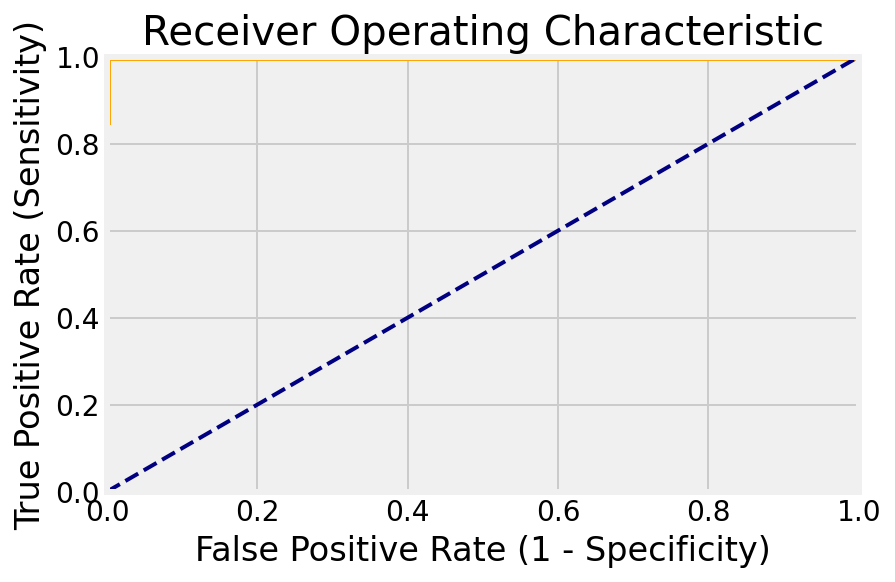

In [437]:
probabilities = pipe_lr.predict_proba(X_test)

roc(probas = probabilities, # pass in series of probabilities 
    true = y_test,          # pass in series of true values
    step=0.001);            # pass in step size

### Let's create very unbalanced classes just for the sake of this example! Generate very unbalanced classes by [bootstrapping](http://stattrek.com/statistics/dictionary.aspx?definition=sampling_with_replacement) (a.k.a. random sampling with replacement) the majority class.

1. The majority class are those individuals with CKD.
2. Generate a random sample of size 200,000 of individuals who have CKD **with replacement**. (Consider setting a random seed for this part!)
3. Create a new dataframe with the original data plus this random sample of data.
4. Now we should have a dataset with around 200,000 observations, of which only about 0.00075% are non-CKD individuals.

In [438]:
ckd_random_sample = ckd[ckd['class'] == 1].sample(200000, replace=True, random_state = 52)

In [439]:
ckd_2 = pd.concat([ckd, ckd_random_sample])

In [440]:
ckd_2.shape 

(200400, 26)

In [441]:
ckd_2['class'].value_counts(normalize=True)

1    0.999251
0    0.000749
Name: class, dtype: float64

### Let's build a logistic regression model on the unbalanced class data and evaluate its performance .

In [443]:
quant = ckd_2[['age', 'bp', 'sg', 'al', 'su', 'bgr',
                 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv',
                 'wbcc', 'rbcc', 'y']]

quant.loc[:,'rbc_abnormal_2'] = pd.get_dummies(ckd_2['rbc'])['abnormal']
quant.loc[:,'pc_abnormal_2'] = pd.get_dummies(ckd_2['pc'])['abnormal']
quant.loc[:,'pcc_present_2'] = pd.get_dummies(ckd_2['pcc'])['present']
quant.loc[:,'ba_present_2'] = pd.get_dummies(ckd_2['ba'])['present']
quant.loc[:,'htn_yes_2'] = pd.get_dummies(ckd_2['htn'])['yes']
quant.loc[:,'dm_yes_2'] = pd.get_dummies(ckd_2['dm'])['yes']
quant.loc[:,'cad_yes_2'] = pd.get_dummies(ckd_2['cad'])['yes']
quant.loc[:,'appet_poor_2'] = pd.get_dummies(ckd_2['appet'])['poor']
quant.loc[:,'pe_yes_2'] = pd.get_dummies(ckd_2['pe'])['yes']
quant.loc[:,'ane_yes_2'] = pd.get_dummies(ckd_2['ane'])['yes']

/Applications/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Applications/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [444]:
quant.shape

(200400, 25)

In [445]:
quant.columns

Index(['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo',
       'pcv', 'wbcc', 'rbcc', 'y', 'rbc_abnormal_2', 'pc_abnormal_2',
       'pcc_present_2', 'ba_present_2', 'htn_yes_2', 'dm_yes_2', 'cad_yes_2',
       'appet_poor_2', 'pe_yes_2', 'ane_yes_2'],
      dtype='object')

In [446]:
X_train, X_test, y_train, y_test = train_test_split(quant.fillna(quant.mean()).drop(['y'],
                                                                                    axis = 1),
                                                    quant['y'],
                                                    test_size = 0.3, 
                                                    random_state = 42)

In [447]:
pipe_lr_2 = Pipeline([
    ('poly', PolynomialFeatures(interaction_only=False, include_bias=False)), 
    ('sc', StandardScaler()),
    ('lr', LogisticRegression())
    ])

In [448]:
cross_val_score(pipe_lr_2, X_train, y_train, cv = 5).mean()

/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

0.9999643570002853

In [449]:
pipe_lr_2.fit(X_train, y_train)

Pipeline(steps=[('poly', PolynomialFeatures(include_bias=False)),
                ('sc', StandardScaler()), ('lr', LogisticRegression())])

In [450]:
pipe_lr_2.score(X_train, y_train)

0.9999857428001141

In [451]:
pipe_lr_2.score(X_test, y_test)

0.9999001996007985

In [452]:
from sklearn.metrics import classification_report

In [453]:
print(classification_report(y_test,
                            pipe_lr_2.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      0.89      0.94        56
           1       1.00      1.00      1.00     60064

    accuracy                           1.00     60120
   macro avg       1.00      0.95      0.97     60120
weighted avg       1.00      1.00      1.00     60120



An unbalanced sample makes a trade-off between precision and sensitivty. 

The more unbalanced it becomes, the lower its true positive rate/sensitivity because of an inability to recognize patterns in the minority class. 

On the other hand, an unbalanced sample increases the ability to recognize patterns in the majority class, increasing its positive predictive value. 

---

## Step 6: Answer the problem.

At this step, we would generally answer the problem! 

In this situation, we'd likely present our model to doctors or admins at the hospital and show how our model results in reduced false positives/false negatives. 

Next steps would be to find a way to roll this model and its conclusions out across the hospital so that the outcomes of patients with CKD (and without CKD!) can be improved!